#### Introduction
- このコードは"OCR model for reading Captchas"を可変長のテキストを持つIAMデータセットに拡張する方法について取り上げる。
- データセットの各サンプルは手書きテキストの画像で、対応するターゲットは画像に存在する文字列である。

#### Data
- データセットがどのように構成されているかプレビューする。
- #で始まる行は単なるメタデータである。

In [1]:
!head -20 data/IAM_Words/words.txt

#--- words.txt ---------------------------------------------------------------#
#
# iam database word information
#
# format: a01-000u-00-00 ok 154 1 408 768 27 51 AT A
#
#     a01-000u-00-00  -> word id for line 00 in form a01-000u
#     ok              -> result of word segmentation
#                            ok: word was correctly
#                            er: segmentation of word can be bad
#
#     154             -> graylevel to binarize the line containing this word
#     1               -> number of components for this word
#     408 768 27 51   -> bounding box around this word in x,y,w,h format
#     AT              -> the grammatical tag for this word, see the
#                        file tagset.txt for an explanation
#     A               -> the transcription for this word
#
a01-000u-00-00 ok 154 408 768 27 51 AT A
a01-000u-00-01 ok 154 507 766 213 48 NN MOVE


#### Setup

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os

import keras
from keras.layers import StringLookup
import tensorflow as tf


#### Dataset splitting

In [3]:
base_path = "data/IAM_Words/"
words_list = []

words = open(f"{base_path}/words.txt", "r").readlines()
for line in words:
    if line[0] == "#":
        continue
    if line.split(" ")[1] != "err": # エラーを除外
        words_list.append(line)

print(len(words_list))
np.random.shuffle(words_list)

96456


In [4]:
# データセットを train:90, validation:5, test:5 の割合で分割
split_idx = int(0.9 * len(words_list))
train_samples = words_list[:split_idx]
test_samples = words_list[split_idx:]

val_split_idx  = int(0.5 * len(test_samples))
validation_samples = test_samples[:val_split_idx]
test_samples = test_samples[val_split_idx:]

assert len(words_list) == len(train_samples) + len(validation_samples) + len(test_samples)

print(f"Total training samples: {len(train_samples)}")
print(f"Toral validation samples: {len(validation_samples)}")
print(f"Total test samples: {len(test_samples)}")

Total training samples: 86810
Toral validation samples: 4823
Total test samples: 4823


#### Data input pipeline

In [5]:
# 画像パスの準備
base_image_path = os.path.join(base_path)

def get_image_paths_and_labels(samples):
    paths = []
    corrected_samples = []
    for (i, file_line) in enumerate(samples):
        line_split = file_line.strip()
        line_split = line_split.split(" ")

        # 各行が分割されると、対応する画像は次のような書式になる: 
        # part1/part1-part2/part1-part2-part3.png
        image_name = line_split[0]
        partI = image_name.split("-")[0]
        partII = image_name.split("-")[1]
        img_path = os.path.join(
            base_image_path, partI, partI + "-" + partII, image_name + ".png"
        )
        if os.path.getsize(img_path):
            paths.append(img_path)
            corrected_samples.append(file_line.split("\n")[0])

    return paths, corrected_samples

train_img_paths, train_labels = get_image_paths_and_labels(train_samples)
validation_img_paths, validation_labels = get_image_paths_and_labels(validation_samples)
test_img_paths, test_labels = get_image_paths_and_labels(test_samples)

In [6]:
# 訓練データから最大長および語彙のサイズを求める
train_labels_cleaned = []
characters = set()
max_len = 0

for label in train_labels:
    label = label.split(" ")[-1].strip()
    for char in label:
        characters.add(char)

    max_len = max(max_len, len(label))
    train_labels_cleaned.append(label)

characters = sorted(list(characters))

print(f"Maximum length: {max_len}")
print(f"Vocab size: {len(characters)}")

# ラベルの確認
train_labels_cleaned[:10]

Maximum length: 21
Vocab size: 78


['believed', ',', 'If', 'fall', 'on', '.', 'Went', 'and', 'fragments', 'with']

In [7]:
def clean_label(labels):
    cleaned_labels = []
    for label in labels:
        label = label.split(" ")[-1].strip()
        cleaned_labels.append(label)
    return cleaned_labels

validation_labels_cleaned = clean_label(validation_labels)
test_labels_cleaned = clean_label(test_labels)

#### Buiding the character vocabulary

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

# 文字を整数にマッピング
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)

# 整数から元の文字にマッピング
num_to_char = StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

#### Resizing images without distortion
- 正方形の画像ではなく、多くのOCRモデルでは長方形の画像を扱う
- アスペクトを意識しない正方形画像のリサイズでは、大きな歪みは生じないが、長方形の画像の場合はそうではない
- 画像を均一にリサイズすることは、ミニバッチの要件である。そこで、以下の基準を満たすようにリサイズを行う必要がある。
    - アスペクト比が保持される
    - 画像の内容が影響を受けない

In [9]:
def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h,w), preserve_aspect_ratio=True)

    # 必要なパッドの量を確認する
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # 両側に同じ量のパッドを入れる場合のみ必要
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2
    
    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0]
        ]
    )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image

#### Putting the utilities together

In [10]:
batch_size = 64
padding_token = 99
image_width = 128
image_height = 32

def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image

def vectorize_label(label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding='UTF-8'))
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0,pad_amount]], constant_values=padding_token)
    return label

def process_images_labels(image_path, label):
    image = preprocess_image(image_path)
    label = vectorize_label(label)
    return {"image": image, "label": label}

def prepare_detaset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)

#### Prepare tf.data.Dataset object

In [11]:
train_ds = prepare_detaset(train_img_paths, train_labels_cleaned)
validation_ds = prepare_detaset(validation_img_paths, validation_labels_cleaned) 
test_ds = prepare_detaset(test_img_paths, test_labels_cleaned)

#### Visualize a few samples

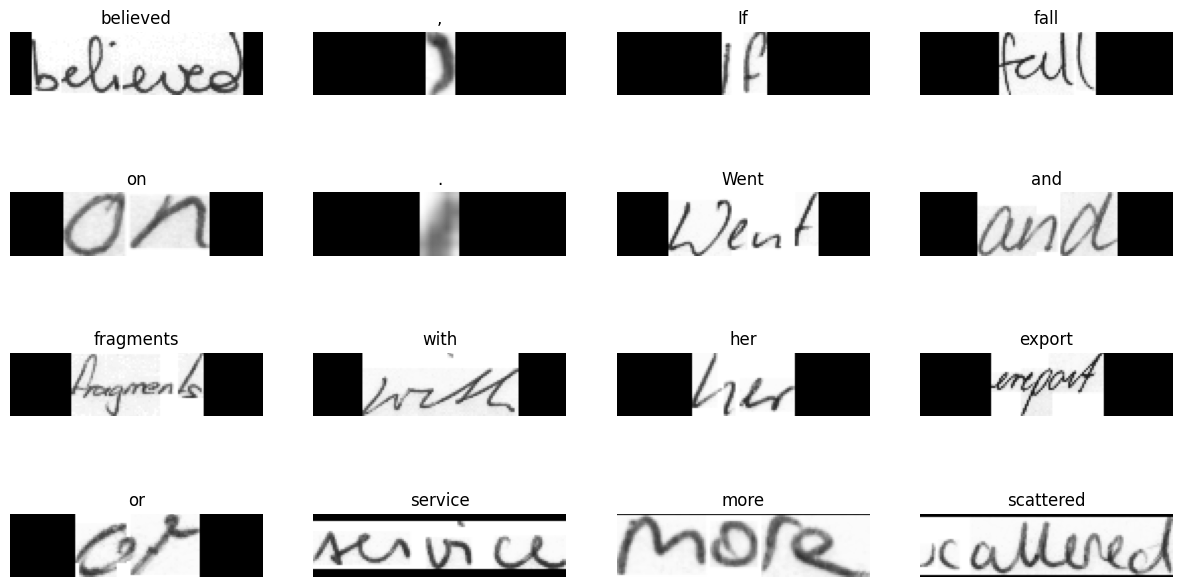

In [12]:
for data in train_ds.take(1):
    images, labels = data["image"], data["label"]

    _, ax = plt.subplots(4,4,figsize=(15,8))

    for i in range(16):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1,0,2])
        img = (img*255.0).numpy().clip(0,255).astype(np.uint8)
        img = img[:,:,0]

        # label = padding_token のインデックスを集める
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # 文字に変換
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 4, i % 4].imshow(img, cmap='gray')
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")

plt.show()

- ↑元画像の内容ができる限り忠実に保たれ、それに応じてpaddingされている

#### Model

In [15]:
class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype='int64')
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype='int64')

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        return y_pred
    
def build_model():
    # 入力層
    input_img = keras.Input(shape=(image_width, image_height, 1), name="image")
    labels = keras.layers.Input(name="label", shape=(None,))

    # First Conv block
    x = keras.layers.Conv2D(
        32,
        (3,3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = keras.layers.MaxPooling2D((2,2), name="pool1")(x)

    # Second Conv block
    x = keras.layers.Conv2D(
        64,
        (3,3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2"
    )(x)
    x = keras.layers.MaxPooling2D((2,2), name="pool2")(x)

    # プールサイズとストライドを2にしたので、2つのMaxPoolingを使用した。
    # 従って、ダウンサンプリングされた特徴量マップは4倍小さくなる。
    # 最終層のフィルター数は64。RNNの部分に出力を渡す前に、それに応じて、Reshapeする
    new_shape = ((image_width // 4), (image_height // 4) * 64)
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = keras.layers.Dense(64, activation="relu", name="dense1")(x)
    x = keras.layers.Dropout(0.2)(x)

    # RNN
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(128, return_sequences=True, dropout=0.25)
    )(x)
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(64, return_sequences=True, dropout=0.25)
    )(x)

    # +2は、CTCの損失によって導入された2つの特別なトークンを考慮したもの。 => ? 
    x = keras.layers.Dense(
        len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2"
    )(x)

    output = CTCLayer(name="ctc_loss")(labels, x)

    # モデル定義
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="handwriting_recognizer"
    )

    # 識別機
    opt = keras.optimizers.legacy.Adam()
    # コンパイル
    model.compile(optimizer=opt)
    return model

# モデルを取得
model = build_model()
model.summary()





Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 128, 32, 1)]         0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 128, 32, 32)          320       ['image[0][0]']               
                                                                                                  
 pool1 (MaxPooling2D)        (None, 64, 16, 32)           0         ['Conv1[0][0]']               
                                                                                                  
 Conv2 (Conv2D)              (None, 64, 16, 64)           18496     ['pool1[0][0]']               
                                                                           

#### Evaluation metrics
- Edit Distanceを用いる
- 検証画像とそのラベルを分離する